# FIFS Sports Big Data Gamethon 2025  

## **Resources**  
Here are key data sources for the competition:  
- **Cricinfo Stats Repository:** [ESPN Cricinfo Stats](https://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;type=batting)  
- **Cricsheet:** [Cricsheet.org](https://cricsheet.org/)  

---

## **Overview**  
The **FIFS Sports Big Data Gamethon 2025** is an AI/ML-powered competition that challenges participants to develop predictive models for **fantasy cricket team selection** during the **ICC Champions Trophy 2025** (Feb 19 - Mar 9, 2025). The goal is to maximize **fantasy points** across all matches by selecting optimal teams based on historical performance, match conditions, and real-time constraints.  

---

## **Objectives of this Notebook**  
This notebook serves as an **introduction to the competition**, outlining the **rules, constraints, and evaluation criteria**. It also lays the foundation for data collection, feature engineering, and model development.  

### **Key Goals**  
- Understand the **gameplay rules** for team selection, budget constraints, and scoring system.  
- Identify the **factors influencing player selection**, such as form, venue, and match conditions.  
- Outline the strategy for **building an AI/ML model** to optimize fantasy team selection.  

---

## **Gameplay Rules & Constraints**  

<details>
  <summary>Team Composition (Click to expand)</summary>  

- A fantasy team consists of **11 players**, matching real-life teams.  
- Each team must include **at least 1 player from both competing teams** in a match.  
- The team must have **at least one player from each category**:  
  - **Wicketkeepers (WK)**  
  - **Batters (BAT)**  
  - **All-rounders (AR)**  
  - **Bowlers (BOWL)**  

</details>  

<details>
  <summary>Budget & Player Credits (Click to expand) </summary>  

- Every player is assigned a **credit value** based on their performance and demand.  
- Participants are given a **budget of 100 player credits** to select their **11 players**.  

</details>  

<details>
  <summary>Backups & Player Replacements (Click to expand) </summary>  

- Participants can select **up to 4 backup players** in case a selected player is not in the final playing XI.  
- Backup players will **only replace non-announced players** and must satisfy all **team composition rules**.  
- ⚠️ Example: If you only select **one bowler** and they are dropped from the playing XI, but none of your backups are bowlers, then the team selection will be invalid.  

</details>  

<details>
  <summary>Fantasy Points System (Click to expand) </summary>  

- Players earn points based on their **match performance** (batting, bowling, fielding).  
- The **official scoring system** for the ICC Champions Trophy can be found **[here](https://www.dream11.com/games/fantasy-cricket/how-to-play?ln=en-US)** under the **One Day (OD) tab**.  

</details>  

---

## **📊 Data Provided**  

<details>
  <summary>Data Sources & Availability (Click to expand) </summary>  

1. **Cricinfo Stats Repository** → [Link](https://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;type=batting)  
2. **Cricsheet** → [Link](https://cricsheet.org/) 

</details>  

---

## **Expected Outcomes**  
By the end of this project, we aim to:  
**Understand the constraints and optimize team selection strategies.**  
**Analyze historical data to extract meaningful player performance trends.**  
**Develop an AI/ML-based model to predict and select the best teams dynamically.**  
**Ensure compliance with fantasy cricket rules while maximizing points.**  

This introduction sets the foundation for our data-driven approach to **fantasy cricket optimization**.

# Data collection

In [1]:
# !pip3 install beautifulsoup4 requests pandas lxml -q

In [2]:
import os
import json
import pandas as pd
import numpy as np

In [3]:
json_folder = './odis_json/'
csv_folder = './odi_csv/'
output_folder = './output/'

match_summary_list = []
player_stats_dict = {}
match_timeseries_data = []

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [4]:
print("Starting the process of reading JSON files from the folder:", json_folder)
print(f"Found {len(os.listdir(json_folder))} files")

print("\n\nProcessing data...")
for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(json_folder, filename)

        try:
            with open(file_path, 'r') as file:
                data = json.load(file)

                match_info = {
                    "match_id": filename.split('.')[0],  # Use filename as match ID
                    "data_version": data.get("meta", {}).get("data_version"),
                    "created": data.get("meta", {}).get("created"),
                    "revision": data.get("meta", {}).get("revision"),
                    "city": data.get("info", {}).get("city"),
                    "dates": data.get("info", {}).get("dates", [])[0] if data.get("info", {}).get("dates") else None,
                    "event_name": data.get("info", {}).get("event", {}).get("name"),
                    "match_number": data.get("info", {}).get("event", {}).get("match_number"),
                    "gender": data.get("info", {}).get("gender"),
                    "match_type": data.get("info", {}).get("match_type"),
                    "match_type_number": data.get("info", {}).get("match_type_number"),
                    "outcome_winner": data.get("info", {}).get("outcome", {}).get("winner"),
                    "outcome_by_runs": data.get("info", {}).get("outcome", {}).get("by", {}).get("runs"),
                    "overs": data.get("info", {}).get("overs"),
                    "player_of_match": data.get("info", {}).get("player_of_match", [])[0] if data.get("info", {}).get("player_of_match") else None,
                    "season": data.get("info", {}).get("season"),
                    "team_type": data.get("info", {}).get("team_type"),
                    "teams": ", ".join(data.get("info", {}).get("teams", [])),
                    "toss_winner": data.get("info", {}).get("toss", {}).get("winner"),
                    "toss_decision": data.get("info", {}).get("toss", {}).get("decision"),
                    "venue": data.get("info", {}).get("venue")
                }

                match_summary_list.append(match_info)

                innings_data = data.get("innings", [])
                match_timeseries_data = []

                # Track match outcome
                match_winner = match_info["outcome_winner"]
                match_loser = None
                if match_winner:
                    match_loser = [team for team in data.get("info", {}).get("teams", []) if team != match_winner][0]

                # Iterate over innings to capture time-series data
                for inning in innings_data:
                    team = inning.get("team")
                    for over_data in inning.get("overs", []):
                        over_number = over_data.get("over")
                        for delivery in over_data.get("deliveries", []):
                            delivery_info = {
                                "match_id": match_info["match_id"],
                                "team": team,
                                "over": over_number,
                                "ball": delivery.get("ball"),
                                "batter": delivery.get("batter"),
                                "bowler": delivery.get("bowler"),
                                "non_striker": delivery.get("non_striker"),
                                "runs_batter": delivery.get("runs", {}).get("batter", 0),
                                "runs_extras": delivery.get("runs", {}).get("extras", 0),
                                "runs_total": delivery.get("runs", {}).get("total", 0),
                                "wicket_player_out": delivery.get("wickets", [{}])[0].get("player_out", None),
                                "wicket_kind": delivery.get("wickets", [{}])[0].get("kind", None)
                            }
                            match_timeseries_data.append(delivery_info)

                            # Player stats aggregation for batting
                            batter = delivery.get("batter")
                            if batter:
                                if batter not in player_stats_dict:
                                    player_stats_dict[batter] = {
                                        "player_name": batter,
                                        "role": "Batter",
                                        "total_runs": 0,
                                        "strike_rate": 0,
                                        "total_balls_faced": 0,
                                        "total_wickets_taken": 0,
                                        "total_runs_conceded": 0,
                                        "total_overs_bowled": 0,
                                        "total_matches_played": 0,
                                        "matches_played_as_batter": 0,
                                        "matches_played_as_bowler": 0,
                                        "matches_won": 0,
                                        "matches_lost": 0,
                                        "player_of_match_awards": 0,
                                        "team": team
                                    }
                                player_stats_dict[batter]["total_runs"] += delivery.get("runs", {}).get("batter", 0)
                                player_stats_dict[batter]["total_balls_faced"] += 1
                                player_stats_dict[batter]["strike_rate"] = (player_stats_dict[batter]["total_runs"] / player_stats_dict[batter]["total_balls_faced"]) * 100

                            # Player stats aggregation for bowling
                            bowler = delivery.get("bowler")
                            if bowler:
                                if bowler not in player_stats_dict:
                                    player_stats_dict[bowler] = {
                                        "player_name": bowler,
                                        "role": "Bowler",
                                        "total_runs": 0,
                                        "strike_rate": 0,
                                        "total_balls_faced": 0,
                                        "total_wickets_taken": 0,
                                        "total_runs_conceded": 0,
                                        "total_overs_bowled": 0,
                                        "total_matches_played": 0,
                                        "matches_played_as_batter": 0,
                                        "matches_played_as_bowler": 0,
                                        "matches_won": 0,
                                        "matches_lost": 0,
                                        "player_of_match_awards": 0,
                                        "team": team
                                    }
                                player_stats_dict[bowler]["total_runs_conceded"] += delivery.get("runs", {}).get("total", 0)
                                player_stats_dict[bowler]["total_overs_bowled"] += 1

                                # Wickets taken by bowler
                                if delivery.get("wickets"):
                                    player_stats_dict[bowler]["total_wickets_taken"] += 1

                # Update match win/loss for players
                if match_winner:
                    for player in player_stats_dict.values():
                        if player["team"] == match_winner:
                            player["matches_won"] += 1
                        elif player["team"] == match_loser:
                            player["matches_lost"] += 1

                # Update player_of_match for award tracking
                player_of_match = match_info["player_of_match"]
                if player_of_match and player_of_match in player_stats_dict:
                    player_stats_dict[player_of_match]["player_of_match_awards"] += 1

                if match_timeseries_data:
                    df_timeseries = pd.DataFrame(match_timeseries_data)
                    output_csv_path = os.path.join(csv_folder, f"{filename.split('.')[0]}.csv")
                    df_timeseries.to_csv(output_csv_path, index=False)

        except json.JSONDecodeError as e:
            print(f"Error: Failed to decode JSON in {filename}. Error: {e}")
        except Exception as e:
            print(f"Error: An unexpected error occurred while processing {filename}. Error: {e}")

# Create match summary DataFrame
if match_summary_list:
    try:
        df_summary = pd.DataFrame(match_summary_list)
        print("Successfully created a DataFrame with the match summary data.")
        print("Summary DataFrame shape:", df_summary.shape)
        # Save the match summary CSV
        df_summary.to_csv(os.path.join(output_folder, 'match_summary.csv'), index=False)
    except Exception as e:
        print(f"Error: Failed to create match summary DataFrame. Error: {e}")

# Separate player stats for batters and bowlers
batters_data = []
bowlers_data = []
if player_stats_dict:
    try:
        for player, stats in player_stats_dict.items():
            if stats["role"] == "Batter":
                batters_data.append(stats)
            elif stats["role"] == "Bowler":
                bowlers_data.append(stats)

        # Create DataFrames for batters and bowlers
        batter_df = pd.DataFrame(batters_data)
        bowler_df = pd.DataFrame(bowlers_data)

        batter_df["total_matches_played"] = batter_df["matches_won"] + batter_df["matches_lost"]
        batter_df["matches_played_as_batter"] = batter_df["total_matches_played"]
        
        bowler_df["total_matches_played"] = bowler_df["matches_won"] + bowler_df["matches_lost"]
        bowler_df["matches_played_as_bowler"] = bowler_df["total_matches_played"]

        print("Successfully created a DataFrame with player statistics.")
        print("Batters Stats DataFrame shape:", batter_df.shape)
        print("Bowlers Stats DataFrame shape:", bowler_df.shape)

        # Save the separate CSVs for batters and bowlers
        batter_df.to_csv(os.path.join(output_folder, 'batter_player_stats.csv'), index=False)
        bowler_df.to_csv(os.path.join(output_folder, 'bowler_player_stats.csv'), index=False)

    except Exception as e:
        print(f"Error: Failed to create player statistics DataFrame. Error: {e}")

print("Process completed.")

Starting the process of reading JSON files from the folder: ./odis_json/
Found 2888 files


Processing data...
Successfully created a DataFrame with the match summary data.
Summary DataFrame shape: (2887, 21)
Successfully created a DataFrame with player statistics.
Batters Stats DataFrame shape: (1540, 15)
Bowlers Stats DataFrame shape: (929, 15)
Process completed.


In [5]:
df_summary.head()

,match_id,data_version,created,revision,city,dates,event_name,match_number,gender,match_type,...,outcome_winner,outcome_by_runs,overs,player_of_match,season,team_type,teams,toss_winner,toss_decision,venue
0,1387601,1.1.0,2023-12-19,1,Gqeberha,2023-12-19,India tour of South Africa,2.0,male,ODI,...,South Africa,NaN,50,T de Zorzi,2023/24,international,"India, South Africa",South Africa,field,"St George's Park, Gqeberha"
1,467883,1.0.0,2010-11-29,2,Guwahati,2010-11-28,New Zealand in India ODI Series,1.0,male,ODI,...,India,40.0,50,V Kohli,2010/11,international,"India, New Zealand",New Zealand,field,Nehru Stadium
2,351689,1.0.0,2013-03-04,1,Perth,2009-02-01,Chappell-Hadlee Trophy,1.0,male,ODI,...,New Zealand,NaN,50,KD Mills,2008/09,international,"Australia, New Zealand",Australia,bat,Western Australia Cricket Association Ground
3,1253268,1.0.0,2021-03-10,1,Lucknow,2021-03-09,South Africa Women tour of India,2.0,female,ODI,...,India,NaN,50,J Goswami,2020/21,international,"South Africa, India",India,field,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...
4,1312806,1.1.0,2022-06-12,2,Pearland,2022-06-11,ICC Men's Cricket World Cup League 2,87.0,male,ODI,...,None,NaN,50,SR Taylor,2022,international,"Nepal, United States of America",Nepal,bat,"Moosa Cricket Stadium, Pearland"


In [6]:
df = df_summary[df_summary['gender'] == 'male'].copy()
df.loc[:, 'created'] = pd.to_datetime(df['created'])

In [7]:
df.head()

,match_id,data_version,created,revision,city,dates,event_name,match_number,gender,match_type,...,outcome_winner,outcome_by_runs,overs,player_of_match,season,team_type,teams,toss_winner,toss_decision,venue
0,1387601,1.1.0,2023-12-19 00:00:00,1,Gqeberha,2023-12-19,India tour of South Africa,2.0,male,ODI,...,South Africa,NaN,50,T de Zorzi,2023/24,international,"India, South Africa",South Africa,field,"St George's Park, Gqeberha"
1,467883,1.0.0,2010-11-29 00:00:00,2,Guwahati,2010-11-28,New Zealand in India ODI Series,1.0,male,ODI,...,India,40.0,50,V Kohli,2010/11,international,"India, New Zealand",New Zealand,field,Nehru Stadium
2,351689,1.0.0,2013-03-04 00:00:00,1,Perth,2009-02-01,Chappell-Hadlee Trophy,1.0,male,ODI,...,New Zealand,NaN,50,KD Mills,2008/09,international,"Australia, New Zealand",Australia,bat,Western Australia Cricket Association Ground
4,1312806,1.1.0,2022-06-12 00:00:00,2,Pearland,2022-06-11,ICC Men's Cricket World Cup League 2,87.0,male,ODI,...,None,NaN,50,SR Taylor,2022,international,"Nepal, United States of America",Nepal,bat,"Moosa Cricket Stadium, Pearland"
5,1377005,1.1.0,2023-06-06 00:00:00,2,Sharjah,2023-06-04,West Indies tour of United Arab Emirates,1.0,male,ODI,...,West Indies,NaN,50,BA King,2023,international,"United Arab Emirates, West Indies",United Arab Emirates,bat,Sharjah Cricket Stadium


In [8]:
df.size

50400

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 0 to 2886
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   match_id           2400 non-null   object 
 1   data_version       2400 non-null   object 
 2   created            2400 non-null   object 
 3   revision           2400 non-null   int64  
 4   city               2119 non-null   object 
 5   dates              2400 non-null   object 
 6   event_name         2386 non-null   object 
 7   match_number       2290 non-null   float64
 8   gender             2400 non-null   object 
 9   match_type         2400 non-null   object 
 10  match_type_number  2400 non-null   int64  
 11  outcome_winner     2277 non-null   object 
 12  outcome_by_runs    1107 non-null   float64
 13  overs              2400 non-null   int64  
 14  player_of_match    2258 non-null   object 
 15  season             2400 non-null   object 
 16  team_type          2400 non-n

# Data analysis

In [10]:
!pip3 install seaborn matplotlib -q

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

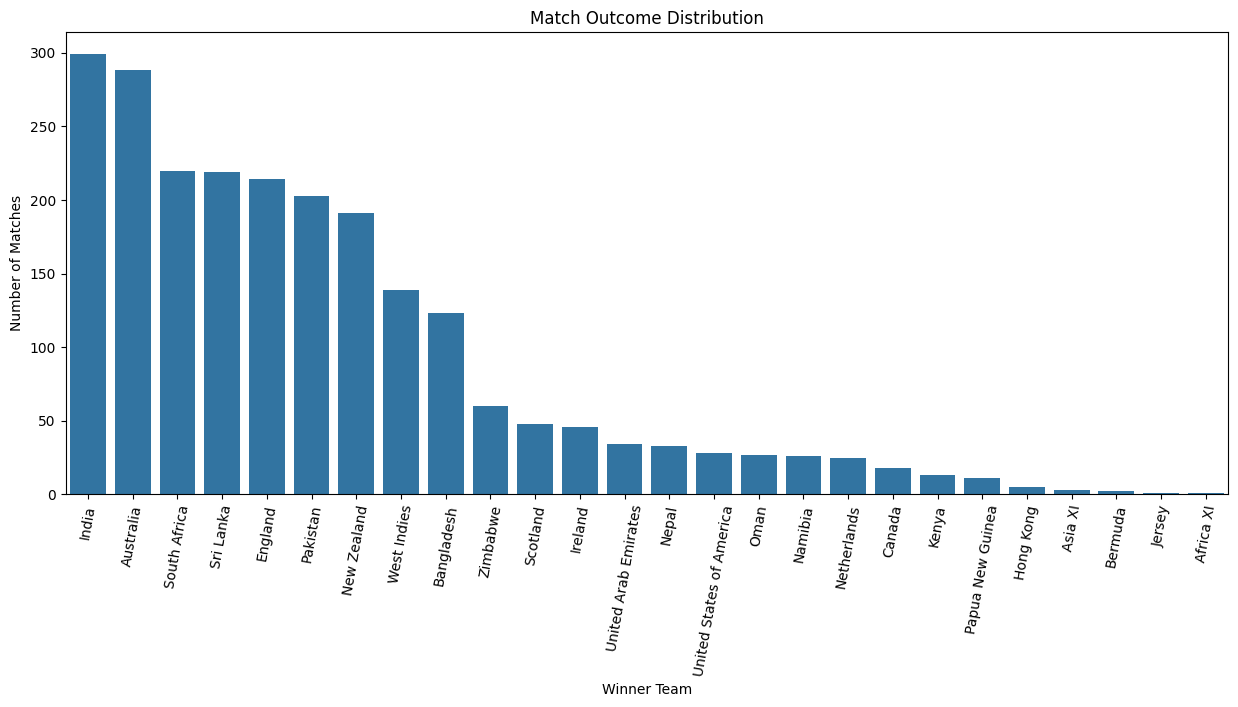

In [12]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='outcome_winner', order=df['outcome_winner'].value_counts().index)
plt.title('Match Outcome Distribution')
plt.ylabel('Number of Matches')
plt.xlabel('Winner Team')
plt.xticks(rotation=80)
plt.show()

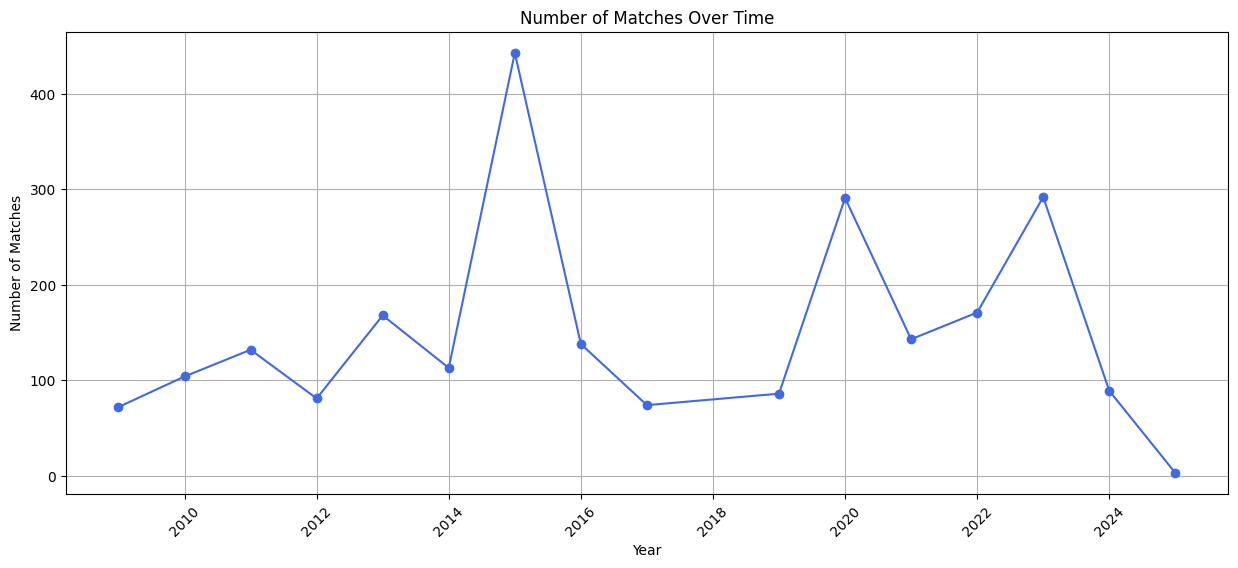

In [13]:
df['created'] = pd.to_datetime(df['created'])

# Match count over time (by year)
plt.figure(figsize=(15, 6))
df.groupby(df['created'].dt.year)['match_id'].count().plot(kind='line', color='royalblue', marker='o')
plt.title('Number of Matches Over Time')
plt.ylabel('Number of Matches')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

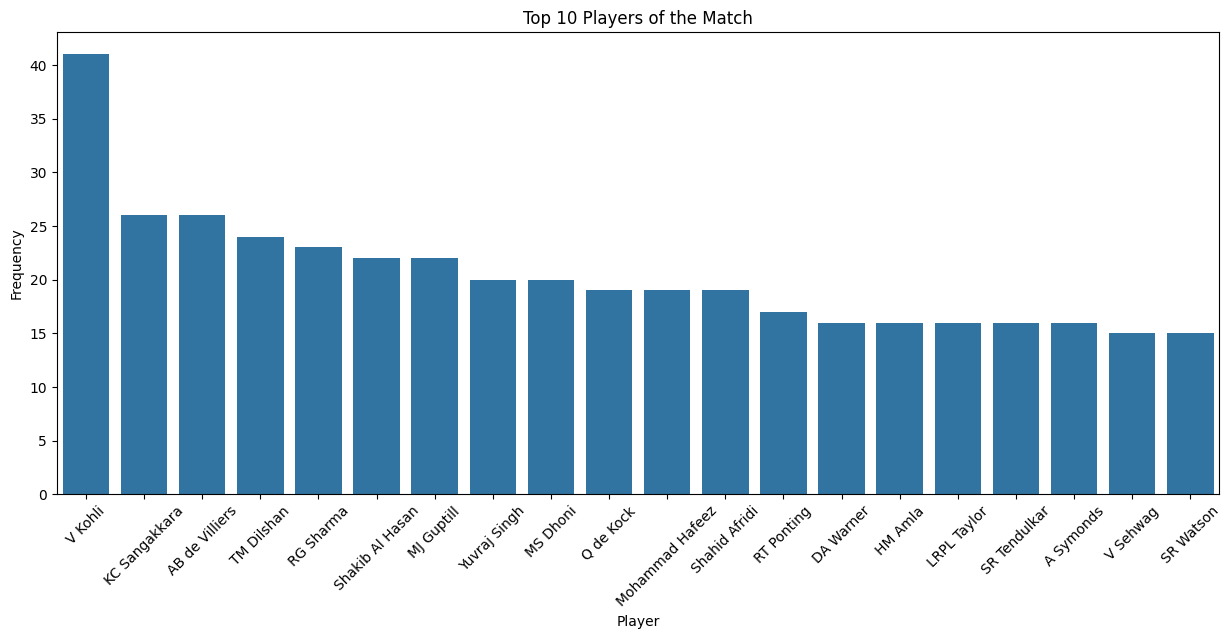

In [14]:
# Player of the match distribution
plt.figure(figsize=(15, 6))
top_players = df['player_of_match'].value_counts().head(20)
sns.barplot(x=top_players.index, y=top_players.values)
plt.title('Top 10 Players of the Match')
plt.xlabel('Player')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

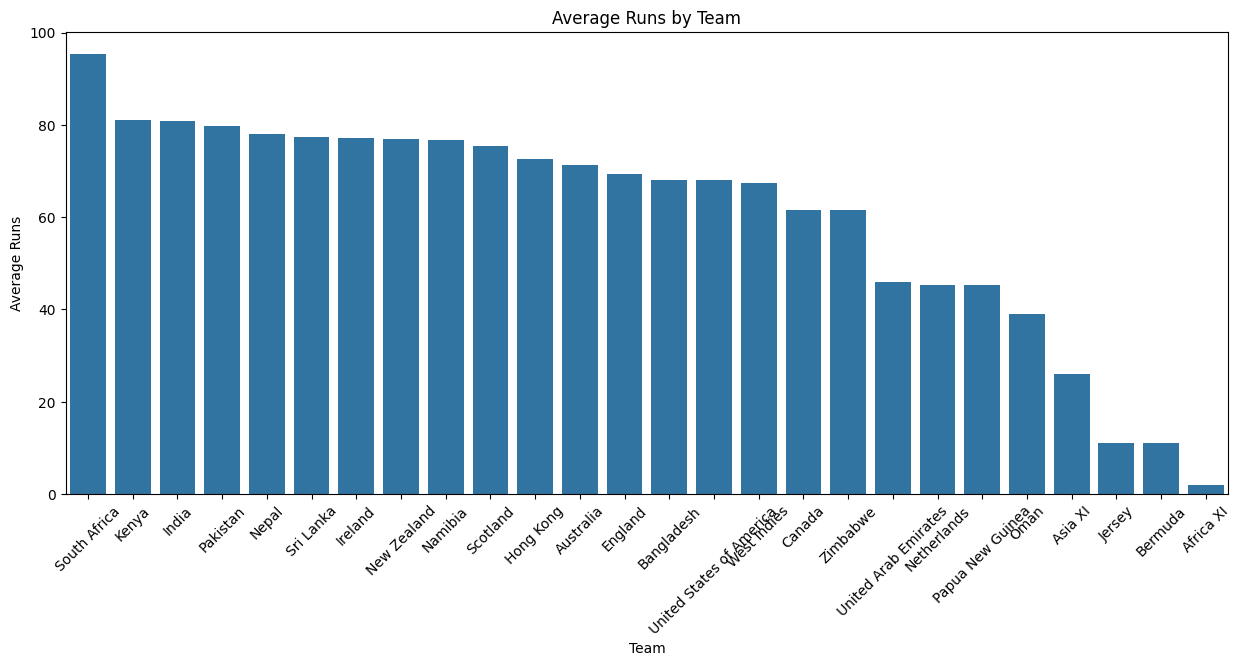

In [15]:
plt.figure(figsize=(15, 6))
team_avg_runs = df.groupby('outcome_winner')['outcome_by_runs'].mean().sort_values(ascending=False)
sns.barplot(x=team_avg_runs.index, y=team_avg_runs.values)
plt.title('Average Runs by Team')
plt.xlabel('Team')
plt.ylabel('Average Runs')
plt.xticks(rotation=45)
plt.show()

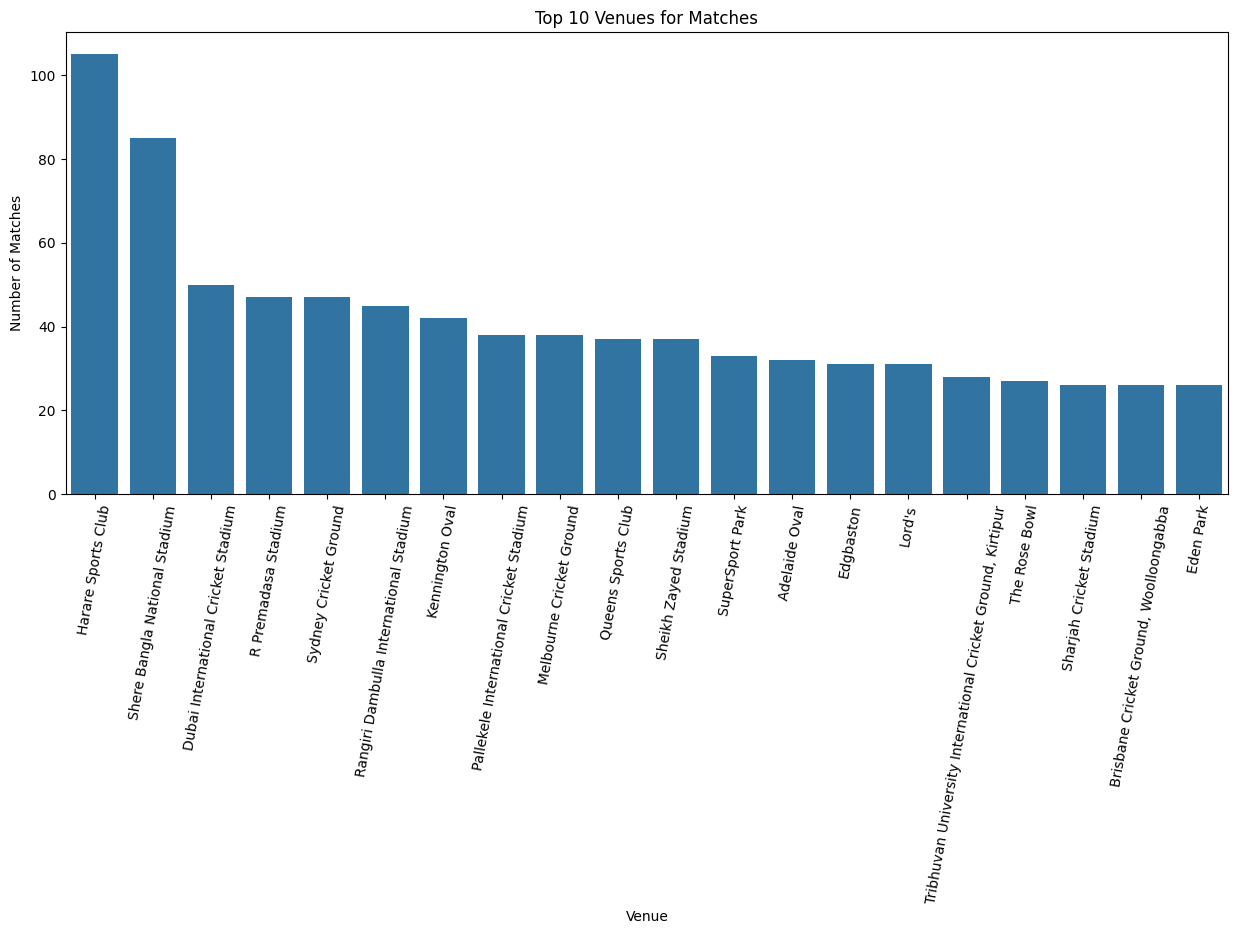

In [16]:
plt.figure(figsize=(15, 6))
top_venues = df['venue'].value_counts().head(20)
sns.barplot(x=top_venues.index, y=top_venues.values)
plt.title('Top 10 Venues for Matches')
plt.xlabel('Venue')
plt.ylabel('Number of Matches')
plt.xticks(rotation=80)
plt.show()

/var/folders/0q/fmdzm8r50gn4cz4_lhqmrx180000gn/T/ipykernel_9606/870774225.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='toss_winner', palette='deep', order=df['toss_winner'].value_counts().index)


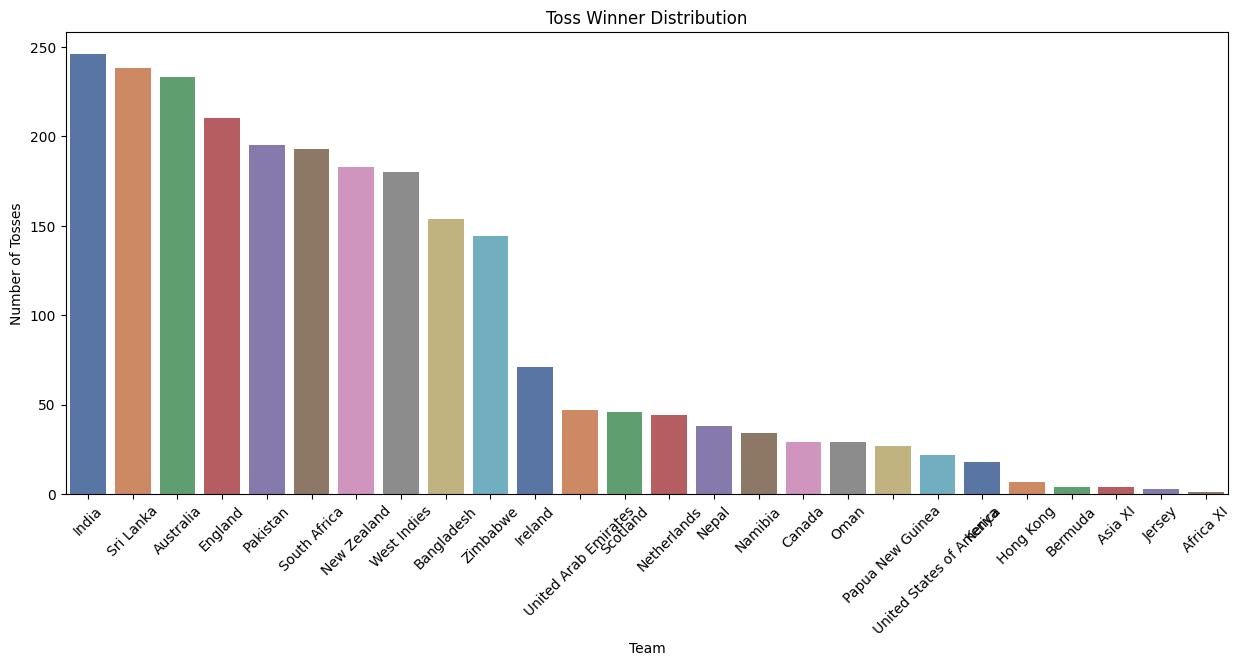

In [17]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='toss_winner', palette='deep', order=df['toss_winner'].value_counts().index)
plt.title('Toss Winner Distribution')
plt.ylabel('Number of Tosses')
plt.xlabel('Team')
plt.xticks(rotation=45)
plt.show()

/var/folders/0q/fmdzm8r50gn4cz4_lhqmrx180000gn/T/ipykernel_9606/2815116528.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='season', palette='inferno', order=df['season'].value_counts().index)


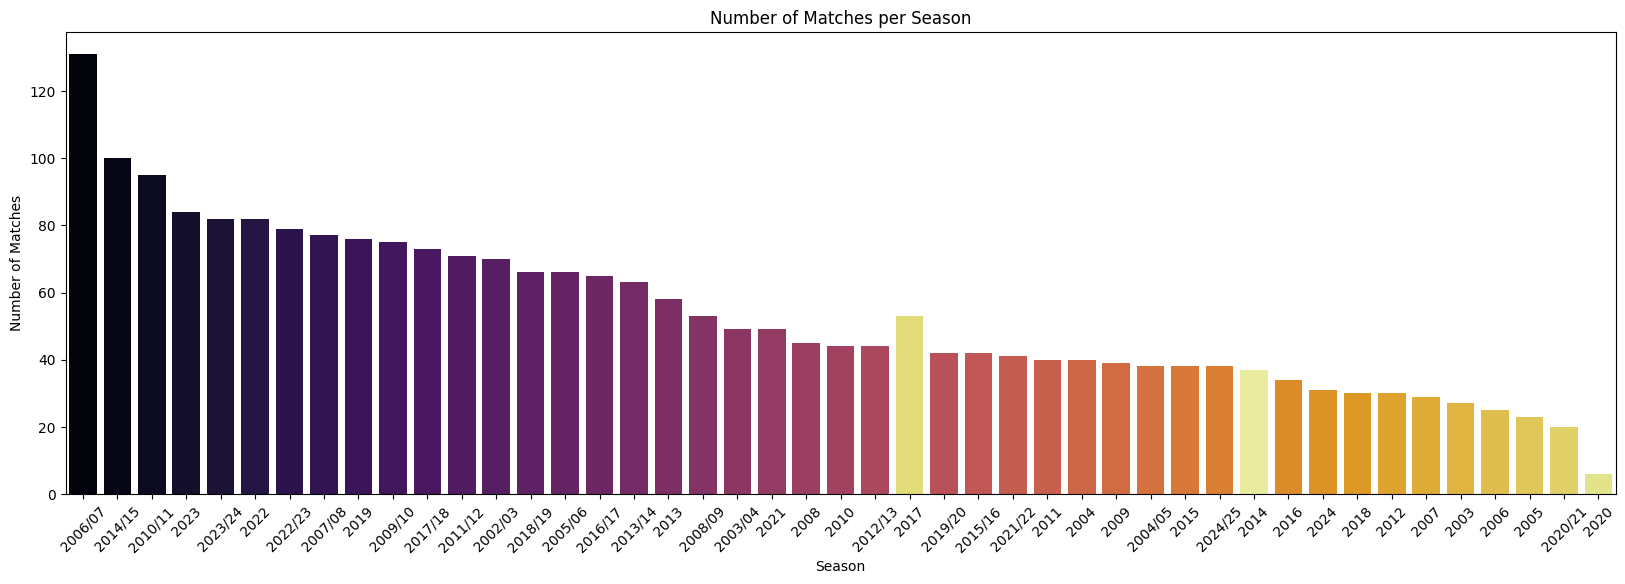

In [18]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='season', palette='inferno', order=df['season'].value_counts().index)
plt.title('Number of Matches per Season')
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.show()

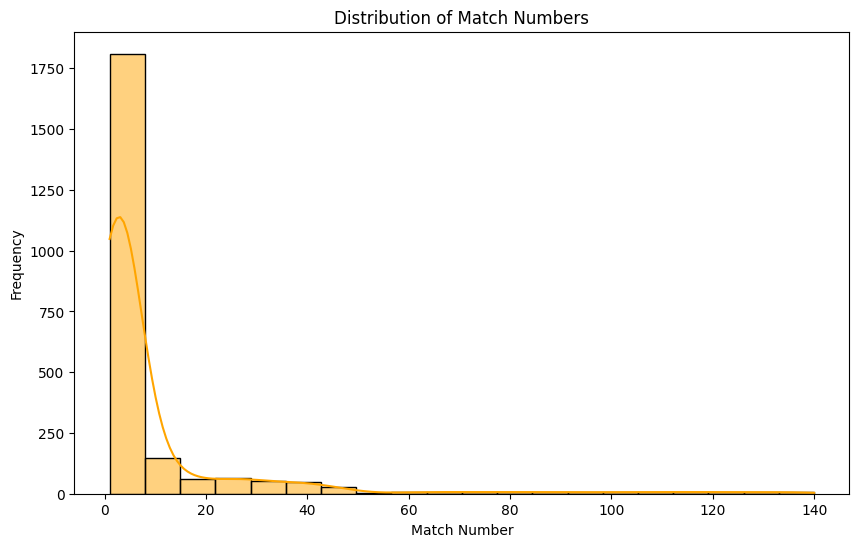

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['match_number'], kde=True, color='orange', bins=20)
plt.title('Distribution of Match Numbers')
plt.xlabel('Match Number')
plt.ylabel('Frequency')
plt.show()

In [20]:
teams = df['teams'].str.split(', ', expand=True).stack().unique()
team_stats = {team: {'matches_played': 0, 'tosses_won': 0, 'matches_won': 0} for team in teams}

In [21]:
for index, row in df.iterrows():
    teams_in_match = row['teams'].split(', ')
    for team in teams_in_match:
        team_stats[team]['matches_played'] += 1
        
        if row['toss_winner'] == team:
            team_stats[team]['tosses_won'] += 1
        
        if row['outcome_winner'] == team:
            team_stats[team]['matches_won'] += 1

In [22]:
matches_df = pd.DataFrame.from_dict(team_stats, orient='index')
matches_df.reset_index(inplace=True)
matches_df.rename(columns={'index': 'team'}, inplace=True)

In [23]:
matches_df = matches_df[['team', 'matches_played', 'tosses_won', 'matches_won']]

matches_df['win_percentage'] = (matches_df['matches_won'] / matches_df['matches_played']) * 100
matches_df['toss_win_percentage'] = (matches_df['tosses_won'] / matches_df['matches_played']) * 100
matches_df['losses'] = matches_df['matches_played'] - matches_df['matches_won']
matches_df['draws'] = df[df['outcome_winner'].isna()]['teams'].apply(lambda x: [team for team in x.split(', ') if team in matches_df['team'].values]).apply(len).sum()  # Adjust this logic as necessary
matches_df['win_to_toss_ratio'] = matches_df['matches_won'] / matches_df['tosses_won'].replace(0, np.nan)

matches_df = matches_df.sort_values(by='win_percentage', ascending=False)

matches_df.head(10)

,team,matches_played,tosses_won,matches_won,win_percentage,toss_win_percentage,losses,draws,win_to_toss_ratio
3,Australia,460,233,288,62.608696,50.652174,172,246,1.236052
24,Asia XI,5,4,3,60.000000,80.000000,2,246,0.750000
0,India,505,246,299,59.207921,48.712871,206,246,1.215447
1,South Africa,373,193,220,58.981233,51.742627,153,246,1.139896
2,New Zealand,370,183,191,51.621622,49.459459,179,246,1.043716
15,Pakistan,396,195,203,51.262626,49.242424,193,246,1.041026
14,England,424,210,214,50.471698,49.528302,210,246,1.019048
20,Oman,55,29,27,49.090909,52.727273,28,246,0.931034
4,Nepal,68,38,33,48.529412,55.882353,35,246,0.868421
19,Scotland,99,46,48,48.484848,46.464646,51,246,1.043478


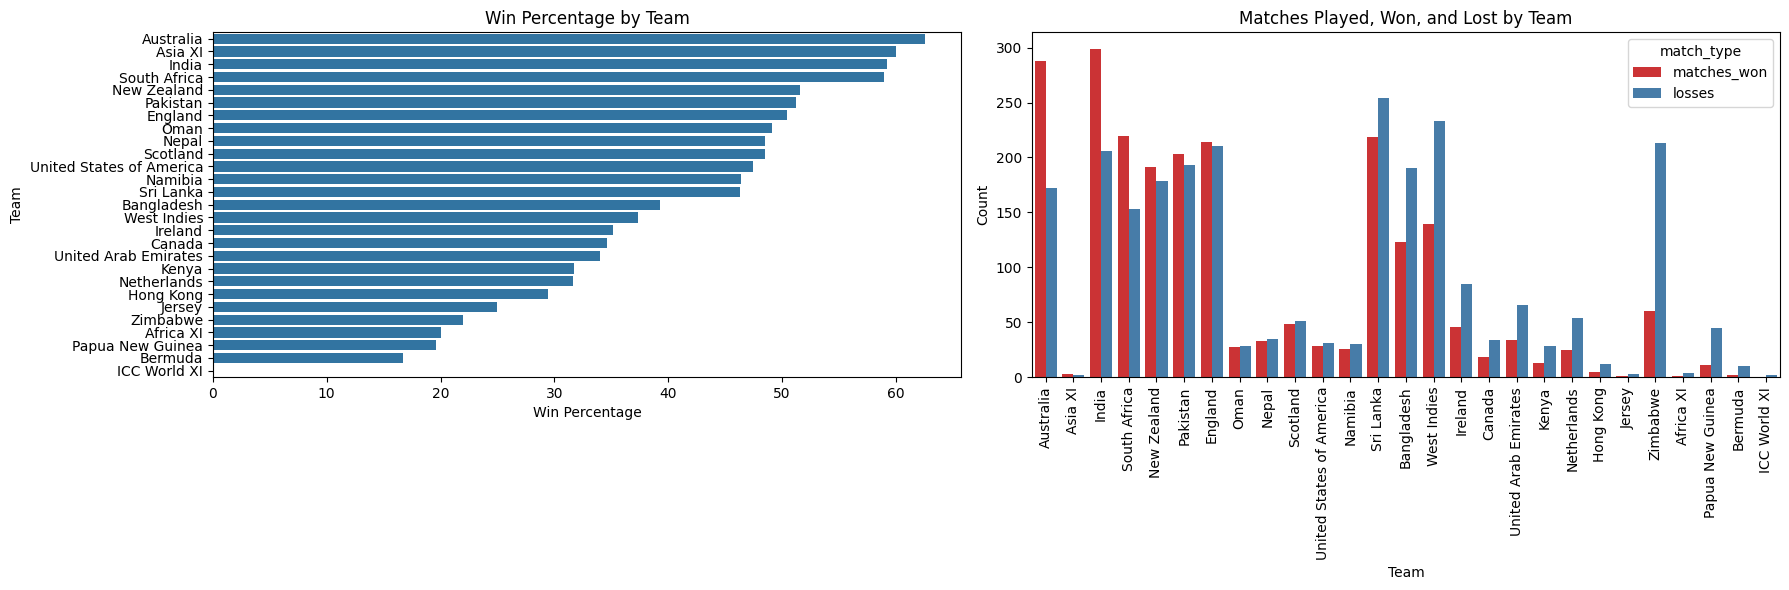

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(data=matches_df, y='team', x='win_percentage', ax=axes[0])
axes[0].set_title('Win Percentage by Team')
axes[0].set_xlabel('Win Percentage')
axes[0].set_ylabel('Team')

df_melted = matches_df.melt(id_vars='team', value_vars=['matches_won', 'losses'], var_name='match_type', value_name='count')
sns.barplot(data=df_melted, x='team', y='count', hue='match_type', palette='Set1', ax=axes[1])
axes[1].set_title('Matches Played, Won, and Lost by Team')
axes[1].set_xlabel('Team')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Player analysis

In [25]:
batter_df = batter_df.sort_values(by=["total_runs", "strike_rate"], ascending=[False, False])
bowler_df = bowler_df.sort_values(by="total_wickets_taken", ascending=False)

In [26]:
batter_df.head(10)

,player_name,role,total_runs,strike_rate,total_balls_faced,total_wickets_taken,total_runs_conceded,total_overs_bowled,total_matches_played,matches_played_as_batter,matches_played_as_bowler,matches_won,matches_lost,player_of_match_awards,team
16,V Kohli,Batter,13784,91.703812,15031,7,681,671,579,579,0,360,219,41,India
198,KC Sangakkara,Batter,11618,79.390461,14634,0,0,0,510,510,0,237,273,26,Sri Lanka
94,RG Sharma,Batter,10646,90.358173,11782,11,538,614,577,577,0,358,219,23,India
195,MS Dhoni,Batter,10274,84.979322,12090,1,32,38,575,575,0,356,219,20,India
263,AB de Villiers,Batter,9435,99.441400,9488,7,205,201,466,466,0,286,180,26,South Africa
196,TM Dilshan,Batter,9212,85.478333,10777,97,4197,5141,510,510,0,237,273,24,Sri Lanka
27,LRPL Taylor,Batter,8126,80.936255,10040,0,35,45,444,444,0,231,213,16,New Zealand
200,DPMD Jayawardene,Batter,8040,78.577013,10232,2,63,72,510,510,0,237,273,12,Sri Lanka
96,HM Amla,Batter,7834,86.487083,9058,0,0,0,470,470,0,290,180,16,South Africa
273,Tamim Iqbal,Batter,7648,76.640946,9979,0,13,7,345,345,0,134,211,13,Bangladesh


In [27]:
bowler_df.head(10)

,player_name,role,total_runs,strike_rate,total_balls_faced,total_wickets_taken,total_runs_conceded,total_overs_bowled,total_matches_played,matches_played_as_batter,matches_played_as_bowler,matches_won,matches_lost,player_of_match_awards,team
133,B Lee,Bowler,865,79.576817,1087,281,6347,8162,509,0,509,236,273,11,Sri Lanka
152,Shakib Al Hasan,Bowler,6638,81.618099,8133,279,8249,10754,467,0,467,226,241,22,Pakistan
246,JM Anderson,Bowler,254,49.416342,514,268,7562,9166,536,0,536,375,161,5,Australia
98,Shahid Afridi,Bowler,3913,131.001004,2987,259,8118,10433,510,0,510,237,273,19,Sri Lanka
104,MA Starc,Bowler,573,75.593668,758,250,5710,6632,427,0,427,165,262,11,West Indies
39,RA Jadeja,Bowler,2731,82.632375,3305,232,7925,9671,544,0,544,381,163,11,Australia
13,TG Southee,Bowler,715,92.857143,770,230,7284,7917,545,0,545,381,164,4,Australia
227,TA Boult,Bowler,216,76.056338,284,219,5190,6230,505,0,505,236,269,9,Sri Lanka
100,KMDN Kulasekara,Bowler,1323,79.698795,1660,213,6792,8200,469,0,469,227,242,4,Pakistan
176,Z Khan,Bowler,531,70.052770,758,211,5702,6806,12,0,12,2,10,5,Bermuda


## Batters analysis

In [28]:
sns.set_style('whitegrid')

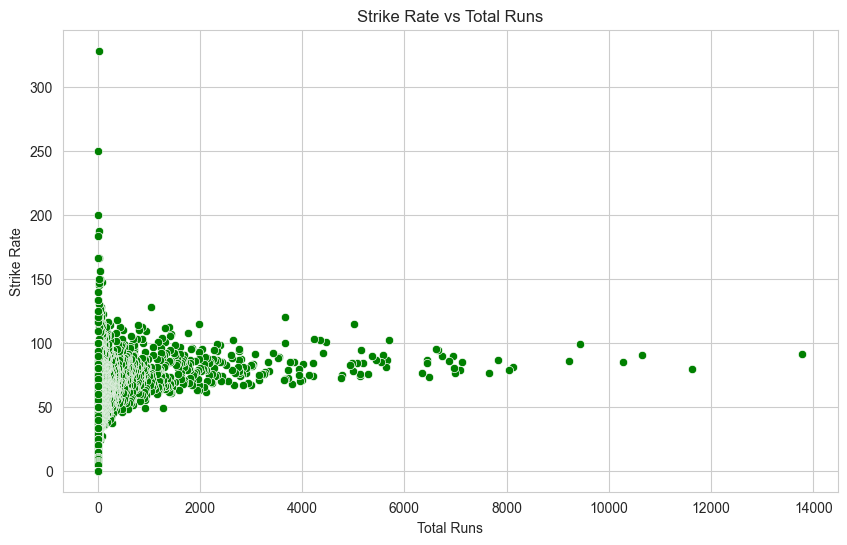

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_runs', y='strike_rate', data=batter_df, color='green')
plt.title('Strike Rate vs Total Runs')
plt.xlabel('Total Runs')
plt.ylabel('Strike Rate')
plt.show()

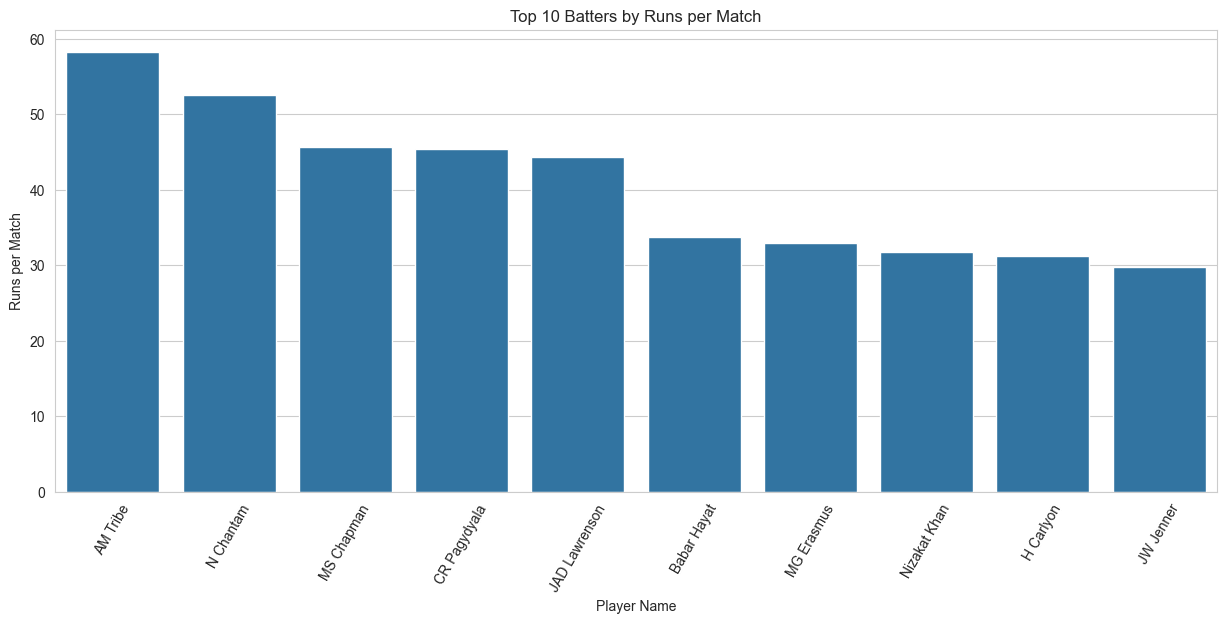

In [32]:
batter_df['runs_per_match'] = batter_df['total_runs'] / batter_df['total_matches_played']
plt.figure(figsize=(15, 6))
sns.barplot(x='player_name', y='runs_per_match', data=batter_df.sort_values(by='runs_per_match', ascending=False).head(10))
plt.title('Top 10 Batters by Runs per Match')
plt.xlabel('Player Name')
plt.ylabel('Runs per Match')
plt.xticks(rotation=60)
plt.show()

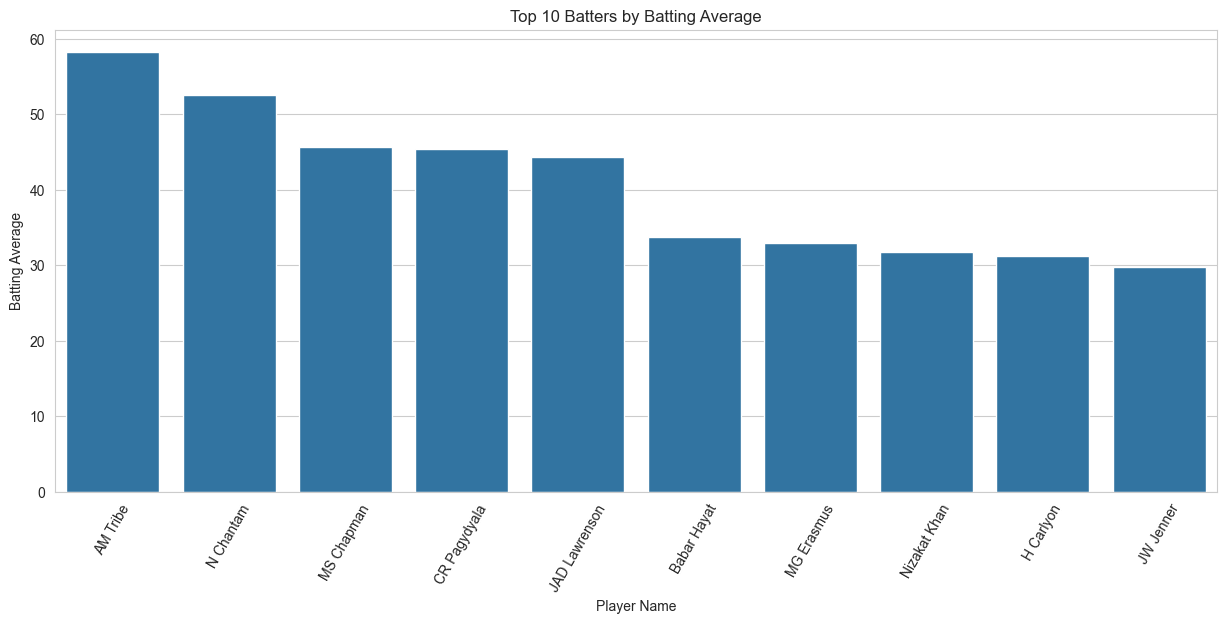

In [35]:
batter_df['batting_average'] = batter_df['total_runs'] / batter_df['total_matches_played']
plt.figure(figsize=(15, 6))
sns.barplot(x='player_name', y='batting_average', data=batter_df.sort_values(by='batting_average', ascending=False).head(10))
plt.title('Top 10 Batters by Batting Average')
plt.xlabel('Player Name')
plt.ylabel('Batting Average')
plt.xticks(rotation=60)
plt.show()

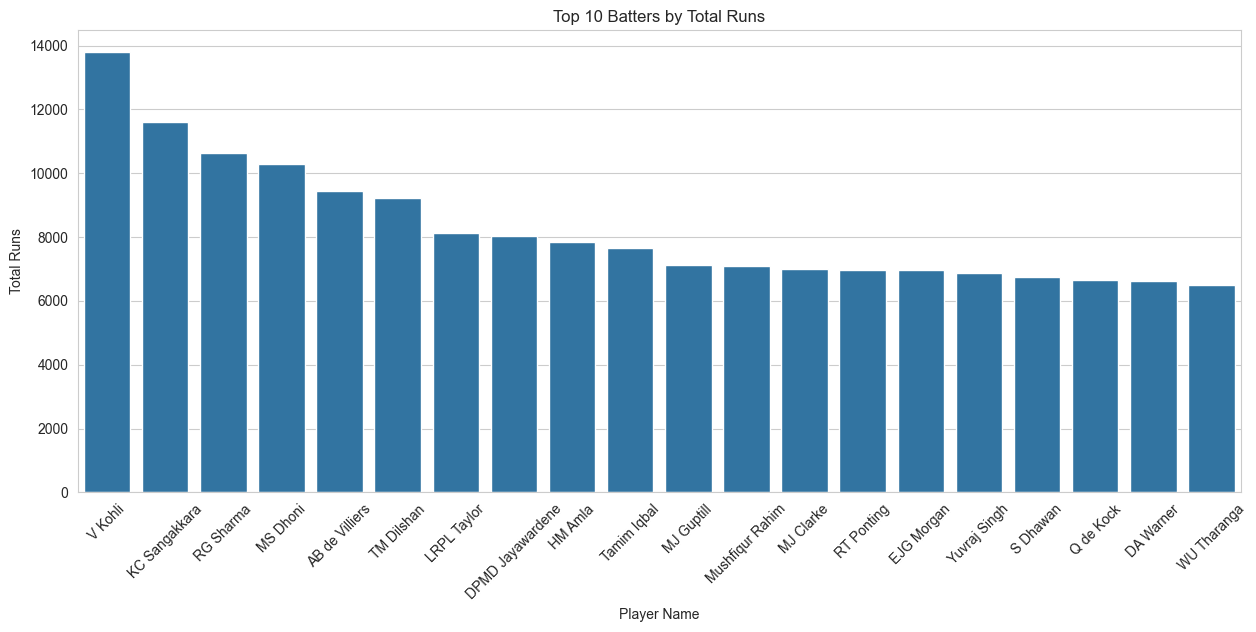

In [38]:
plt.figure(figsize=(15, 6))
sns.barplot(x='player_name', y='total_runs', data=batter_df.sort_values(by='total_runs', ascending=False).head(20))
plt.title('Top 10 Batters by Total Runs')
plt.xlabel('Player Name')
plt.ylabel('Total Runs')
plt.xticks(rotation=45)
plt.show()

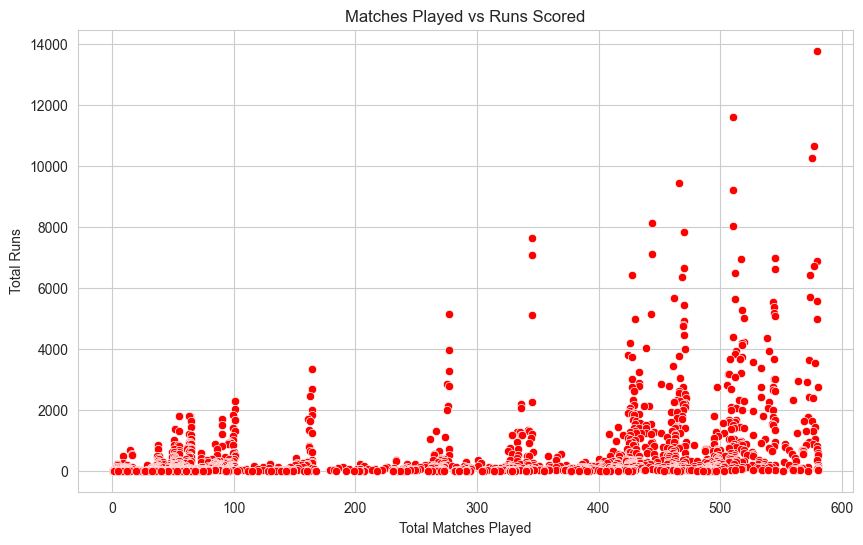

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_matches_played', y='total_runs', data=batter_df, color='red')
plt.title('Matches Played vs Runs Scored')
plt.xlabel('Total Matches Played')
plt.ylabel('Total Runs')
plt.show()

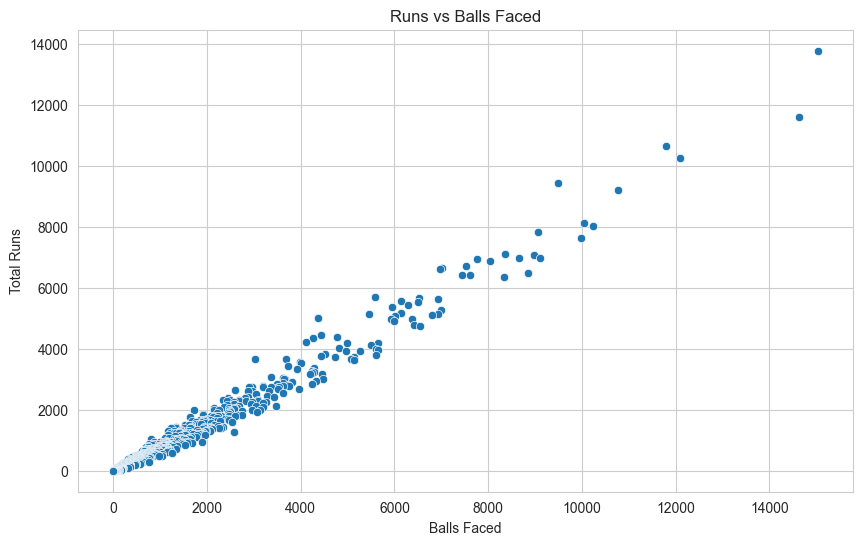

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_balls_faced', y='total_runs', data=batter_df)
plt.title('Runs vs Balls Faced')
plt.xlabel('Balls Faced')
plt.ylabel('Total Runs')
plt.show()

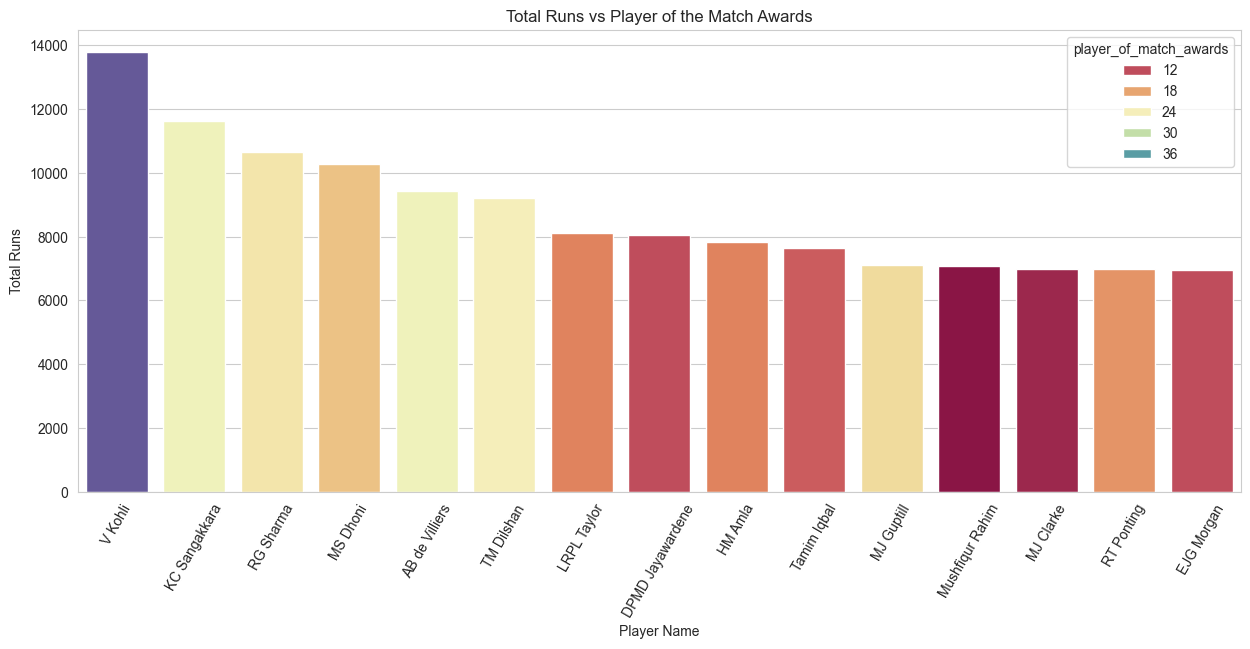

In [48]:
plt.figure(figsize=(15, 6))
sns.barplot(x='player_name', y='total_runs', data=batter_df.sort_values(by='total_runs', ascending=False).head(15), hue='player_of_match_awards', palette='Spectral')
plt.title('Total Runs vs Player of the Match Awards')
plt.xlabel('Player Name')
plt.ylabel('Total Runs')
plt.xticks(rotation=60)
plt.show()

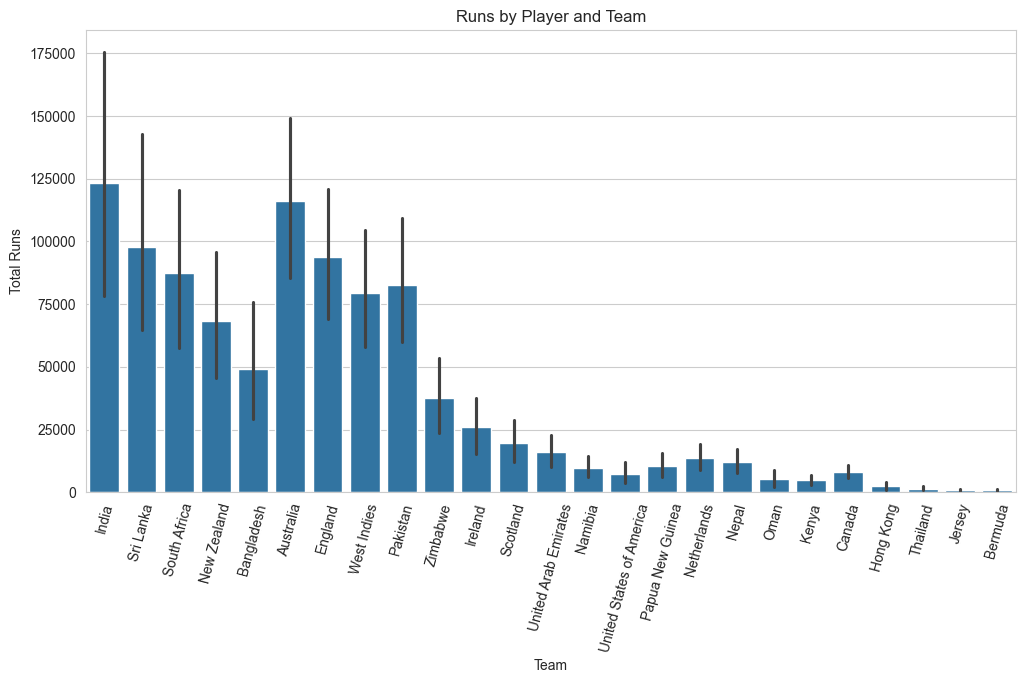

In [52]:
plt.figure(figsize=(12, 6))
sns.barplot(x='team', y='total_runs', data=batter_df, estimator='sum')
plt.title('Runs by Player and Team')
plt.xlabel('Team')
plt.ylabel('Total Runs')
plt.xticks(rotation=75)
plt.show()

## Bowlers Analysis

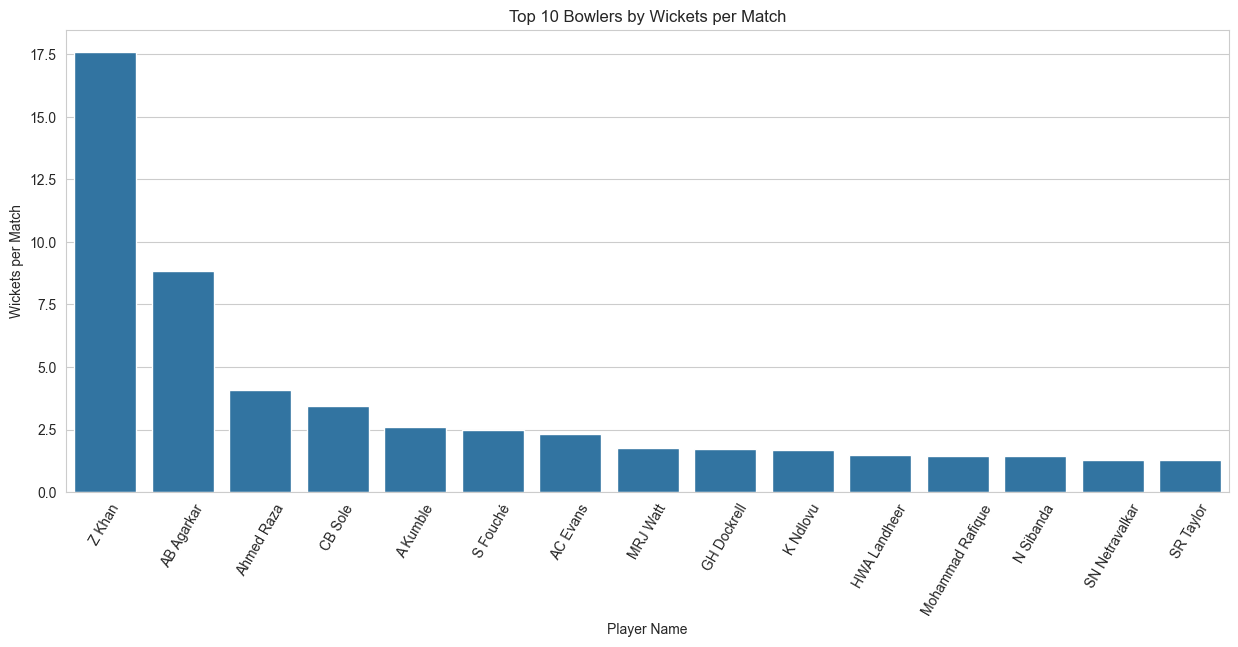

In [56]:
bowler_df['wickets_per_match'] = bowler_df['total_wickets_taken'] / bowler_df['total_matches_played']
plt.figure(figsize=(15, 6))
sns.barplot(x='player_name', y='wickets_per_match', data=bowler_df.sort_values(by='wickets_per_match', ascending=False).head(15))
plt.title('Top 10 Bowlers by Wickets per Match')
plt.xlabel('Player Name')
plt.ylabel('Wickets per Match')
plt.xticks(rotation=60)
plt.show()

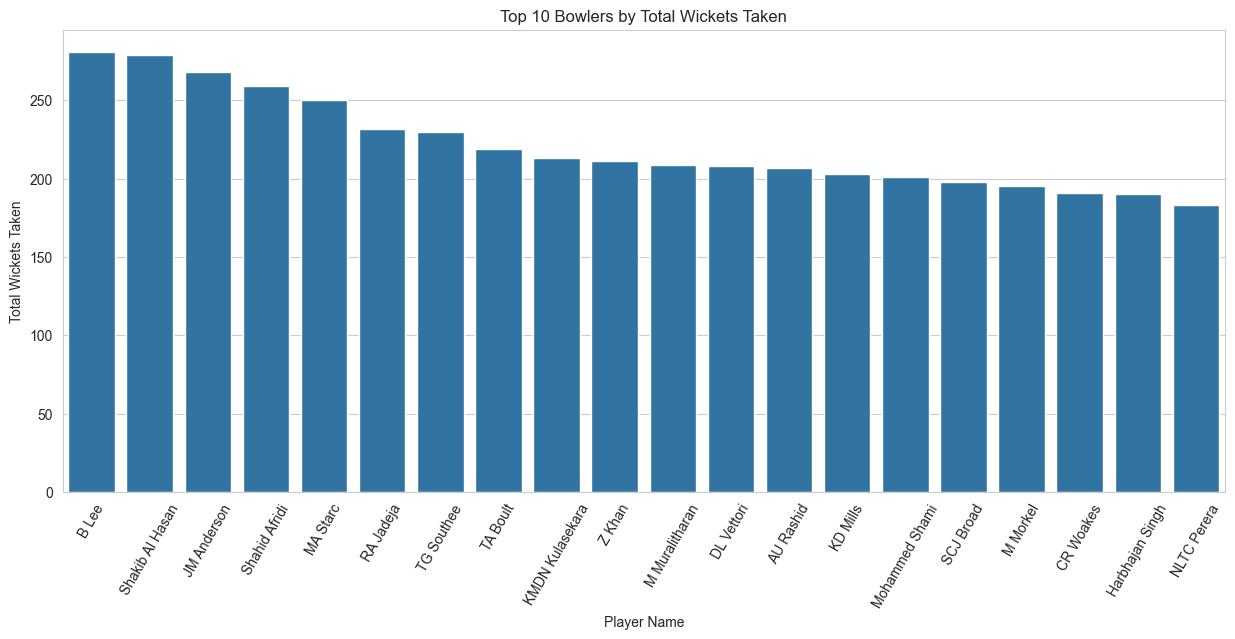

In [60]:
plt.figure(figsize=(15, 6))
sns.barplot(x='player_name', y='total_wickets_taken', data=bowler_df.sort_values(by='total_wickets_taken', ascending=False).head(20))
plt.title('Top 10 Bowlers by Total Wickets Taken')
plt.xlabel('Player Name')
plt.ylabel('Total Wickets Taken')
plt.xticks(rotation=60)
plt.show()

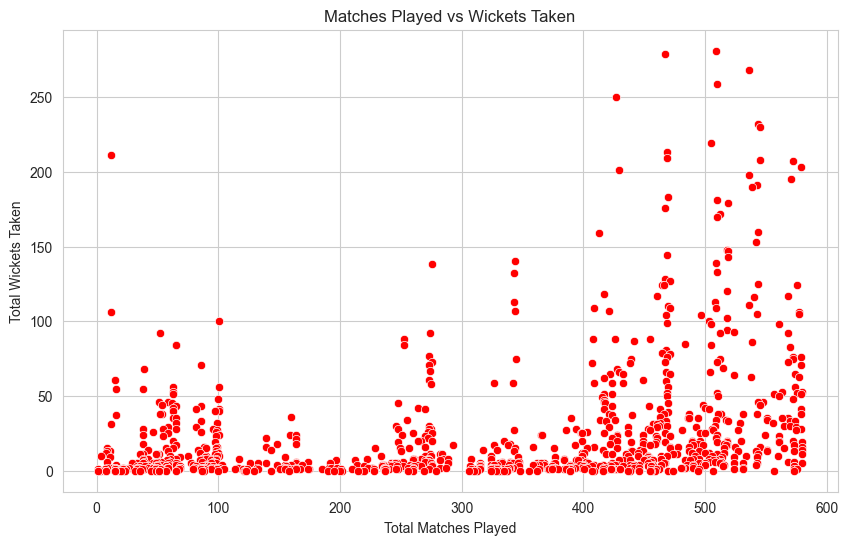

In [61]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_matches_played', y='total_wickets_taken', data=bowler_df, color='red')
plt.title('Matches Played vs Wickets Taken')
plt.xlabel('Total Matches Played')
plt.ylabel('Total Wickets Taken')
plt.show()